In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [ ]:
tf.config.experimental.list_logical_devices()

2024-06-02 10:32:16.630800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-02 10:32:16.663828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-02 10:32:16.664075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-02 10:32:16.664666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_SIZE = 300
BATCH_SIZE = 16

# path_data = "./raw_data_dir/data-deon"
path_data = "./data-test"
path_data = "./drive/MyDrive/EducaTour/data-test"


data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_data,
    shuffle=True,
#     color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

classes=data.class_names
print("Class names:", classes)

Found 1300 files belonging to 25 classes.
Class names: ['benteng_vredeburg', 'candi_borobudur', 'candi_prambanan', 'garuda_wisnu_kencana', 'gedung_sate', 'istana_maimun', 'jam_gadang', 'keong_mas', 'keraton_jogja', 'kota_tua', 'lawang_sewu', 'masjid_istiqlal', 'masjid_menara_kudus', 'masjid_raya_baiturrahman', 'menara_siger_lampung', 'monas', 'monumen_bandung_lautan_api', 'monumen_gong_perdamaian', 'monumen_nol_km', 'monumen_simpang_lima_gumul', 'patung_ikan_surabaya', 'patung_yesus_memberkati', 'tugu_jogja', 'tugu_khatulistiwa', 'tugu_pahlawan_surabaya']


# Image Processing

In [ ]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

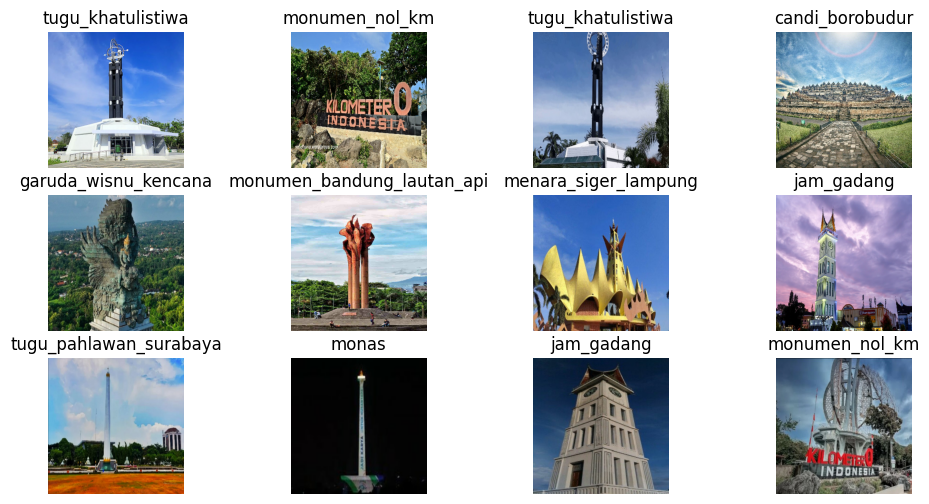

In [ ]:
plt.figure(figsize=(12, 6))
for img_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.title(f"{classes[label_batch[i]]}")
        plt.axis("Off")
        plt.imshow(img_batch[i].numpy().astype("int"), cmap='gray');

# Splitting Data

In [ ]:
len_data=len(data)

# Shuffle data
data=data.shuffle(buffer_size=10000, seed=42)

train_size=int(len_data*0.90)
# val_size=int(len_data*0.7)

train_data=data.take(train_size)
val_data=data.skip(train_size)
# test_data=data.skip(train_size).skip(val_size)

print(f"""Length of data in each batch
ori data: {len_data}
train data: {len(train_data)}
val data: {len(val_data)}
""")

Length of data in each batch
ori data: 82
train data: 73
val data: 9



# Augmenting Data

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.13),
])

# Creating Model

### Plotting Utility

In [ ]:
def plot_history(model, seq_1, seq_2):
    plt.plot(model.history[seq_1], label=seq_1)
    plt.plot(model.history[seq_2], label=seq_2)
    plt.legend()
    plt.title("training history");

## Model 1

In [ ]:
IMG_SHAPE=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)

model_1 = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(25, activation="softmax"),
], name="model_1")

In [ ]:
model_1.build(input_shape=IMG_SHAPE)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 300, 300, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 298, 298, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (16, 149, 149, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 147, 147, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 73, 73, 64)          0         
 g2D)                                                      

In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
%%time
history_1 = model_1.fit(
    train_data,
    epochs=50,
    verbose=1,
    validation_data=val_data,
)

Epoch 1/50


2024-06-02 10:32:21.137012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


73/73 [==============================] - 19s 170ms/step - loss: 3.2181 - accuracy: 0.0424 - val_loss: 3.1172 - val_accuracy: 0.1319
Epoch 2/50
73/73 [==============================] - 13s 152ms/step - loss: 3.0183 - accuracy: 0.1107 - val_loss: 2.8118 - val_accuracy: 0.1806
Epoch 3/50
73/73 [==============================] - 13s 151ms/step - loss: 2.7925 - accuracy: 0.1825 - val_loss: 2.3606 - val_accuracy: 0.2292
Epoch 4/50
73/73 [==============================] - 13s 152ms/step - loss: 2.4801 - accuracy: 0.2457 - val_loss: 2.2720 - val_accuracy: 0.3333
Epoch 5/50
73/73 [==============================] - 13s 153ms/step - loss: 2.3045 - accuracy: 0.3166 - val_loss: 2.2144 - val_accuracy: 0.3542
Epoch 6/50
73/73 [==============================] - 13s 153ms/step - loss: 2.0666 - accuracy: 0.3867 - val_loss: 1.8267 - val_accuracy: 0.4097
Epoch 7/50
73/73 [==============================] - 13s 153ms/step - loss: 1.9410 - accuracy: 0.4377 - val_loss: 1.6818 - val_accuracy: 0.5069
Epoch 8/50

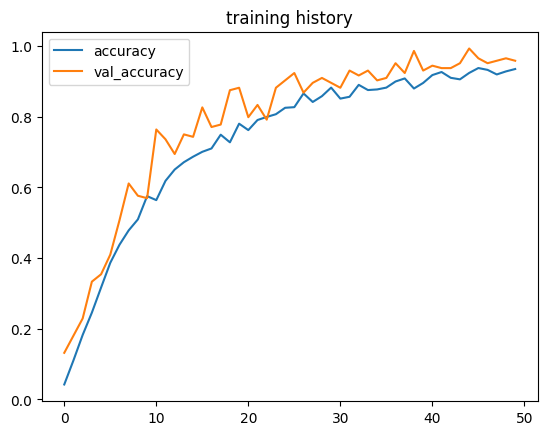

In [ ]:
plot_history(history_1, "accuracy", "val_accuracy")

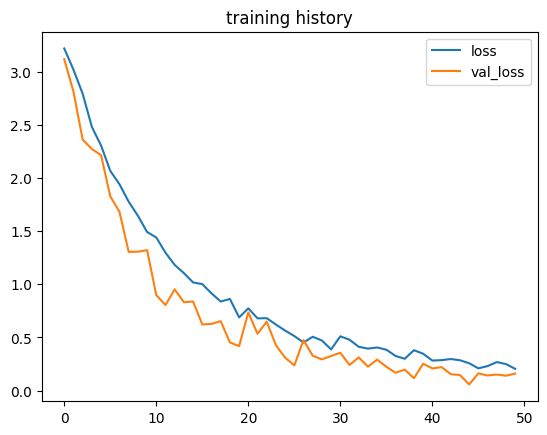

In [ ]:
plot_history(history_1, "loss", "val_loss")

In [ ]:
model_1.save("history/model_1.h5")

## Model 2
Using InceptionV3

### Split dir to train and val

In [ ]:
import os
import shutil
import random

source_p = "./data-test/"
dest_p = "./tmp/"
split_dir = ["training", "validation"]
split_size = 0.9

LABELS = sorted(
    [
        "monas", "kota_tua", "gedung_sate", "candi_borobudur", "candi_prambanan", "lawang_sewu", "keraton_jogja",
        "monumen_bandung_lautan_api", "benteng_vredeburg", "jam_gadang", "patung_ikan_surabaya", "tugu_jogja",
        "garuda_wisnu_kencana", "masjid_raya_baiturrahman", "masjid_istiqlal", "monumen_nol_km", "tugu_khatulistiwa",
        "monumen_simpang_lima_gumul", "menara_siger_lampung", "istana_maimun", "patung_yesus_memberkati", "tugu_pahlawan_surabaya",
        "keong_mas", "monumen_gong_perdamaian", "masjid_menara_kudus"
    ])

# def split_to_train_val_dir(dest_dir, source_dir, labels, train_dir, val_dir, split_size):

#     for d in ["training","validation"]:
#         for sd in labels:
#             os.makedirs(os.path.join(dest_dir, d, sd))

#     list_dir = os.listdir(source_dir)
#     shuffled_data = random.sample(list_dir, len(list_dir))

sts=True
list_source_p = sorted(os.listdir(source_p))
while sts:
    try:
        for d in split_dir:
            for sd in LABELS:
                os.makedirs(os.path.join(dest_p, d, sd))
        sts=False
    except FileExistsError:
        shutil.rmtree(dest_p)

for i, d in enumerate(list_source_p):
    p = os.path.join(source_p, d)
#     print("###### data", LABELS[i])
    for y, sd in enumerate(os.listdir(p)):
        len_f = int(len(os.listdir(p)) * split_size)
        p_source = os.path.join(p, sd)

        if y < len_f:
            nye = split_dir[0] #training
        else:
            nye = split_dir[1] #validation

        p_dest = os.path.join(dest_p, nye, LABELS[i], sd)
        shutil.copyfile(p_source, p_dest)

### Creating model_2 Architecture

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [ ]:
input_tensor = tf.keras.Input(shape=(300,300,3))

base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights="imagenet")

for layer in base_model.layers[:140]:
    layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_98[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
model_2_inp = base_model.input
model_2_inp

<KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
last_output = base_model.get_layer("mixed7").output

In [ ]:
last_output

<KerasTensor: shape=(None, 17, 17, 768) dtype=float32 (created by layer 'mixed7')>

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(25, activation="softmax")(x)

model_2 = Model(inputs=input_tensor, outputs=x, name="model_2")
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_98[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

### Prepare Data and Train

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "./drive/MyDrive/EducaTour/tmp/training"
val_dir = "./drive/MyDrive/EducaTour/tmp/validation"

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=10,
                                #    width_shift_range=0.2,
                                #    height_shift_range=0.2,
                                #    shear_range=0.2,
                                #    zoom_range=0.2,
                                   fill_mode="nearest",
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=16,
    class_mode="categorical",
    target_size=(300, 300)
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=16,
    class_mode="categorical",
    target_size=(300, 300)
)

Found 1150 images belonging to 25 classes.
Found 150 images belonging to 25 classes.
